In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

input_path="D:\DataSets\churn_modelling.csv"
#  A way to tackle the various represents of missing values other than "NA" is to add values to a list
missing_values = ["n/a", "na", "--"]
frame=pd.read_csv(input_path,index_col=None,na_values = missing_values)
frame.rename(columns={"EstimatedSalary":"EstSalary"},inplace=True)
df=frame[frame.columns.to_list()[3:]]

# Missing values check
df.isnull().sum()
df.head(4)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0


In [14]:
#one hot encoding on gender column
# df['Gender'] = df['Gender'].apply(lambda x: 1 if x=='Female' else 0)
df.Gender = np.where(df.Gender =="Male", 1,0)
df.head()



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [15]:

corr=df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstSalary,Exited
CreditScore,1,-0.0029,-0.004,0.00084,0.0063,0.012,-0.0055,0.026,-0.0014,-0.027
Gender,-0.0029,1,-0.028,0.015,0.012,-0.022,0.0058,0.023,-0.0081,-0.11
Age,-0.004,-0.028,1,-0.01,0.028,-0.031,-0.012,0.085,-0.0072,0.29
Tenure,0.00084,0.015,-0.01,1,-0.012,0.013,0.023,-0.028,0.0078,-0.014
Balance,0.0063,0.012,0.028,-0.012,1,-0.3,-0.015,-0.01,0.013,0.12
NumOfProducts,0.012,-0.022,-0.031,0.013,-0.3,1,0.0032,0.0096,0.014,-0.048
HasCrCard,-0.0055,0.0058,-0.012,0.023,-0.015,0.0032,1,-0.012,-0.0099,-0.0071
IsActiveMember,0.026,0.023,0.085,-0.028,-0.01,0.0096,-0.012,1,-0.011,-0.16
EstSalary,-0.0014,-0.0081,-0.0072,0.0078,0.013,0.014,-0.0099,-0.011,1,0.012
Exited,-0.027,-0.11,0.29,-0.014,0.12,-0.048,-0.0071,-0.16,0.012,1


In [16]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [17]:
F, p = stats.f_oneway(df[df.Geography=='France'].EstSalary,
                      df[df.Geography=='Germany'].EstSalary,
                      df[df.Geography=='Spain'].EstSalary)
print(F,p)

0.5827609114534064 0.5583736355799094


In [18]:
# Method 1 to use groupby using dataframe mean function
grouped=df.groupby('Geography').mean()

# Method 2 grouped_data['rt'].aggregate(np.mean).reset_index()

grouped

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstSalary,Exited
Geography,,,,,,,,,,
France,649.668329,0.549063,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548
Germany,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Spain,651.333872,0.560355,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734


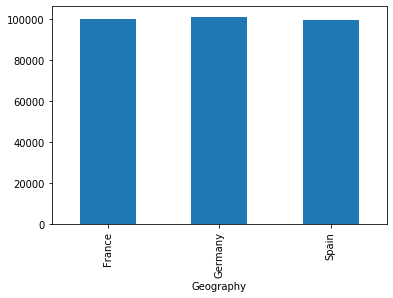

In [19]:
grouped.EstSalary.plot(kind='bar')
# Not much variation in the average of the estimated salary in 3 countires


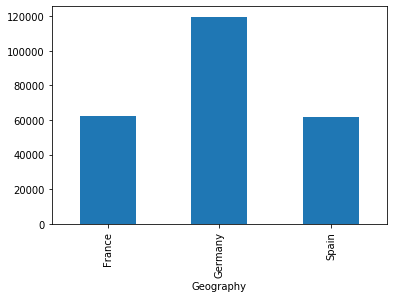

In [20]:
# Understand the significance of F and p values to proceed further to check the estimated salary variation between geography
grouped.Balance.plot(kind='bar') 
# Germany with high balance

1    5457
0    4543
Name: Gender, dtype: int64

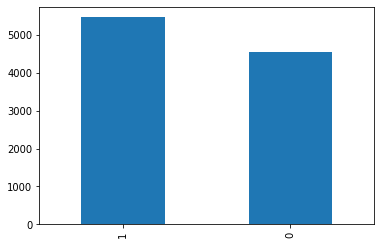

In [21]:
df.Gender.value_counts().plot(kind='bar')
# Male 1, Female 0
df.Gender.value_counts()

In [22]:
#Performed one hot encoding on geography column
X=df.copy(deep=True)
X['Geo_Ger']=np.where(X['Geography']=="Germany",1,0)
X['Geo_Spain']=np.where(X['Geography']=="Spain",1,0)
X['Geo_France']=np.where(X['Geography']=="France",1,0)
X = X.drop(["Exited","Geography"], axis=1)
y = df["Exited"]
# implementing train-test-split on the data
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.4, random_state=66)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

In [33]:
model = RandomForestClassifier(n_estimators=10)
model.fit(train_data,train_target)

scores = cross_val_score(model, train_data, train_target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores

Accuracy: 0.85 (+/- 0.01)


array([0.85095754, 0.84929226, 0.85666667, 0.84653878, 0.85654712])

In [34]:
# Accuracy on test data
rfc_predict = model.predict(test_data)
confusion_matrix(test_target, rfc_predict)
accuracy_score(test_target,rfc_predict)


0.852